In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def init_random(x, k):
    d = int(x.shape[1])
    random_samples = np.random.choice(len(x), k)
    return x[random_samples]

def euc_dist(a, b):
    return np.sqrt(np.sum(np.square(a - b)))

In [13]:
#Plotting functions
def plot_lloyds(x, all_centers=None):
    plt.scatter(x[:, 0], x[:, 1], alpha=0.8, s=10)
    if all_centers:
        colors = plt.get_cmap('Reds')(np.linspace(0, 1, len(all_centers)))
        for i, centers in enumerate(all_centers):
            if i == len(all_centers) - 1:
                m = '*'
            else:
                m = '.'
            if i > 0:
                for j in range(len(centers)):
                    plt.plot(
                        [centers[j][0], all_centers[i-1][j][0]],
                        [centers[j][1], all_centers[i-1][j][1]],
                        linewidth=1,
                        marker=m,
                        markersize=15 * (i+1)/len(all_centers),
                        color=colors[i],
                        markeredgecolor=colors[i],
                    )
    plt.show()
    
def visualize_costs(centers, min_vals, max_vals):
    x_range = np.arange(min_vals[0], max_vals[0])
    y_range = np.arange(min_vals[1], max_vals[1])
    costs = np.zeros((len(x_range), len(y_range)))
    for i, x in enumerate(x_range):
        for j, y in enumerate(y_range):
            costs[i, j] = error(np.array([x, y]), centers)

    fig = plt.figure()
    X, Y = np.meshgrid(x_range, y_range)
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, costs.T, alpha=0.7)
    in_bounds_centers = (min_vals[0] < centers[:, 0]) * (centers[:, 0] < max_vals[0]) * (min_vals[1] < centers[:, 1]) * (centers[:, 1] < max_vals[1])
    ax.scatter(centers[in_bounds_centers, 0], centers[in_bounds_centers, 1], np.zeros(np.sum(in_bounds_centers)), c='r', marker='*')
    plt.show()

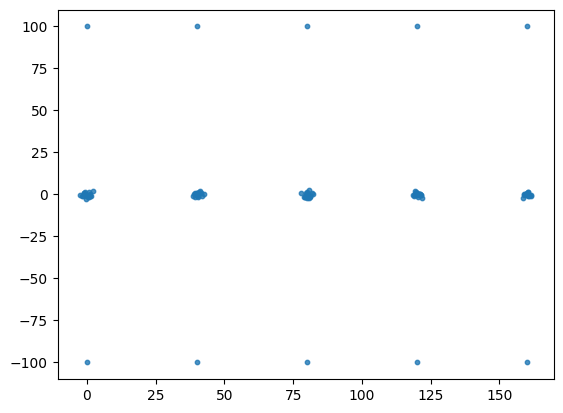

In [14]:
np.random.seed(123)
def create_artificial_bad_dataset(n, k=15, vert_spacing=100, horiz_spacing=None):
    """
    Create a dataset of k clusters where 1/3 of the clusters have O(n) points.
    The other clusters each have size O(1).
    Lloyd's algorithm will perform arbitrarily poorly on this dataset.
    """
    if k % 3 != 0:
        raise ValueError("Artificial bad dataset needs k to be divisible by 3")
    if horiz_spacing is None:
        horiz_spacing = 6 * vert_spacing / k
    
    # assume dimensionality is 2 so it's easy to plot
    points = np.zeros((n, 2))
    for column in range(int(k/3)):
        x = horiz_spacing * column
        points[int(column * 3 * n / k)] = [column * horiz_spacing, vert_spacing]
        points[int((column+1) * 3 * n / k - 1)] = [column * horiz_spacing, -vert_spacing]
        points[int(column * 3 * n / k + 1) : int((column+1) * 3 * n / k - 1)] = np.random.multivariate_normal([column * horiz_spacing, 0], [[1, 0], [0, 1]], [int(3 * n / k - 2)]) 
        
    return points

plot_lloyds(create_artificial_bad_dataset(100))

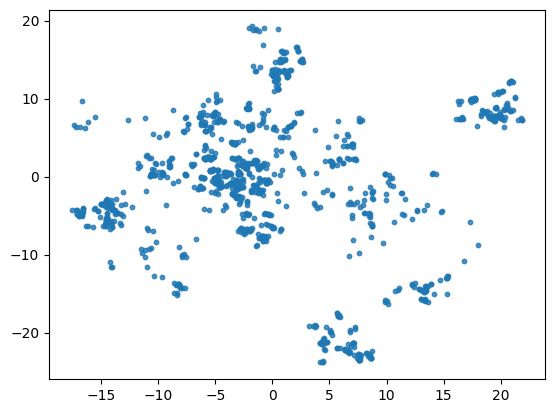

In [15]:
def create_hierarchical_clusters(n, x=0, y=0, std_dev=100, d=2, recursive_prob=0.35):
    """
    Create a dataset that samples from a Gaussian distribution.
    For each sample, recursively sample points from its neighborhood with some likelihood.
    This creates a normally distributed ball of Gaussian clusters where each cluster has a sub-cluster within it.
    """
    if n <= 1:
        return np.random.multivariate_normal([x, y], [[std_dev, 0], [0, std_dev]], 1)
    
    samples = np.random.multivariate_normal([x, y], [[std_dev, 0], [0, std_dev]], n)
    points = []
    for point in samples:
        if np.random.uniform() < recursive_prob:
            points.append(
                create_hierarchical_clusters(
                    n=int(np.random.uniform() * n/2),
                    x=point[0],
                    y=point[1],
                    std_dev=std_dev/50,
                    d=d,
                    recursive_prob=recursive_prob
                )
            )
            
    if points:
        points = np.concatenate(points, axis=0)
        return points
    return np.empty([0, 2])

plot_lloyds(create_hierarchical_clusters(100))

In [16]:
# TO DO BY STUDENTS

def get_assignments(points, centers):
    assignments = -1 * np.ones(len(points))
    for i, point in enumerate(points):
        min_dist = np.inf
        closest_center = None
        for j, center in enumerate(centers):
            point_center_dist = euc_dist(point, center)
            if point_center_dist < min_dist:
                min_dist = point_center_dist
                closest_center = j
        assignments[i] = closest_center
    return assignments.astype(np.int32)

def error(points, centers):
    assignments = get_assignments(points, centers)
    cost = 0
    for i, point in enumerate(points):
        cost += np.square(euc_dist(point, centers[assignments[i]]))
        
    return cost

def lloyds_step(points, centers):
    # Get all cluster assignments given x and c
    n, d = points.shape
    k = centers.shape[0]
    assignments = get_assignments(points, centers)
    
    # Assign new centers to the means of the clusters
    new_centers = np.zeros((k, d))
    for c in range(len(centers)):
        point_inds = np.where(assignments == c)
        new_centers[c] = np.mean(x[point_inds], axis=0)
        
    return new_centers

In [17]:
def lloyds(x, k, init, tol=1e-5, max_steps=100):
    all_centers = [init(x, k)]
    step = 0
    cost = error(x, all_centers[-1])
    loss_change = np.inf
    while loss_change > tol and step < max_steps:
        all_centers.append(lloyds_step(x, all_centers[-1]))
        new_cost = error(x, all_centers[-1])
        loss_change = cost - new_cost
        cost = new_cost
        step += 1
        print(cost)
        
    return all_centers

13455.159148835673
10825.29734564846
9912.5635752701
9276.106139079255
8560.062963238419
7960.603089956259
7413.446645994957
6730.924288688763
6332.6078267991215
6164.989077094177
6104.432490839704
6103.87872936417
6103.87872936417


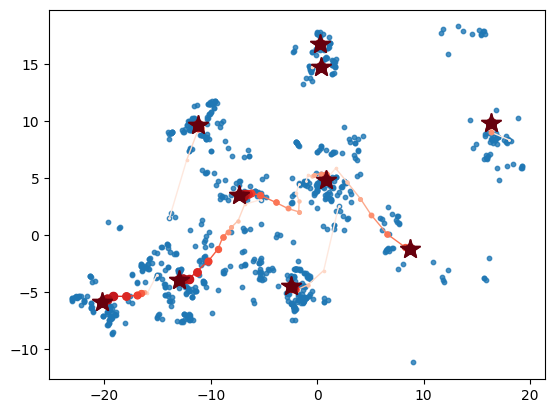

Here is a look at the cost of a point over the input space:


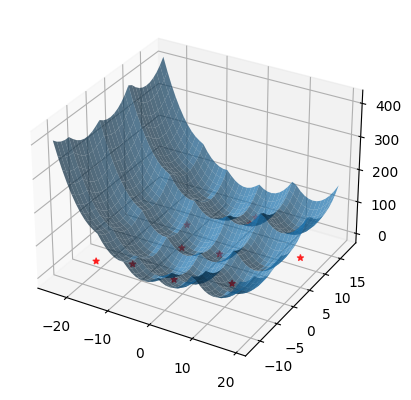

Now let's zoom in on the middle 50 percent of points:


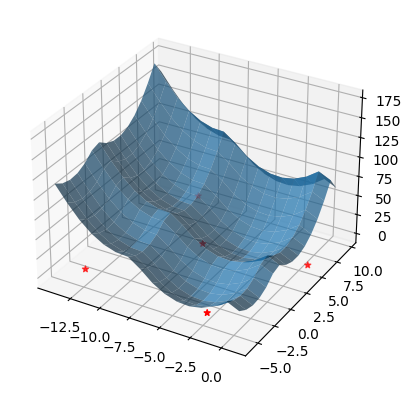

In [33]:
x = create_hierarchical_clusters(100)
all_centers = lloyds(x, 10, init_random)
plot_lloyds(x, all_centers)

print('Here is a look at the cost of a point over the input space:')
visualize_costs(
    all_centers[-1],
    [np.floor(np.min(x[:, 0])), np.floor(np.min(x[:, 1]))],
    [np.ceil(np.max(x[:, 0])), np.ceil(np.max(x[:, 1]))],
)

print('Now let\'s zoom in on the middle 50 percent of points:')
visualize_costs(
    all_centers[-1],
    [np.percentile(x[:, 0], 15), np.percentile(x[:, 1], 15)],
    [np.percentile(x[:, 0], 85), np.percentile(x[:, 1], 85)],
)

48723.55049358758
20125.05573536271
20125.05573536271


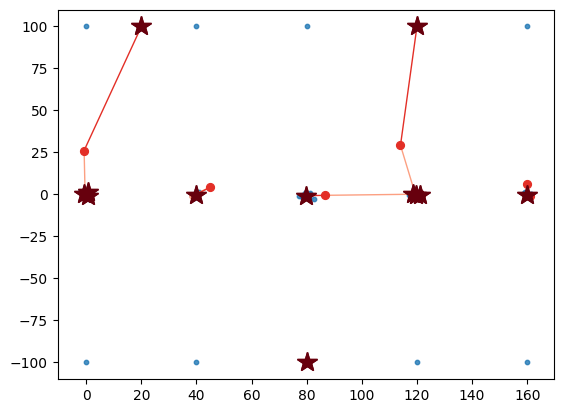

In [34]:
k = 15
x = create_artificial_bad_dataset(100, k)
all_centers = lloyds(x, k, init_random)
plot_lloyds(x, all_centers)

In [38]:
# TODO BY STUDENTS

def get_min_dists_to_centers(points, new_center, dists):
    if dists is None:
        dists = np.ones((len(points))) * np.inf
    if len(new_center.shape) == 1:
        new_center = np.expand_dims(new_center, axis=0)
    new_dists = np.sum((points - new_center) ** 2, axis=-1)
    improved_inds = new_dists < dists
    dists[improved_inds] = new_dists[improved_inds]
    return dists

def init_kmeans_plusplus(points, k):
    n, d = int(points.shape[0]), int(points.shape[1])
    centers = [np.random.choice(n)]
    sq_dists = None
    for i in range(k-1):
        sq_dists = get_min_dists_to_centers(points, points[np.array(centers)[-1]], sq_dists)
        if np.sum(sq_dists) > 0:
            probs = sq_dists / np.sum(sq_dists)
        else:
            probs = np.ones_like(probs) / len(probs)
        centers.append(np.random.choice(n, p=probs))
    return points[centers]

18646.312598817643
12632.565885606444
10629.236364978264
10063.92741850796
10011.762714178743
9948.12943800531
9828.90814152266
9314.199503343127
8758.786755181914
8712.370326467817
8651.583376878569
8624.615362714394
8624.25455867805
8624.054086324813
8623.925547638019
8623.925547638019


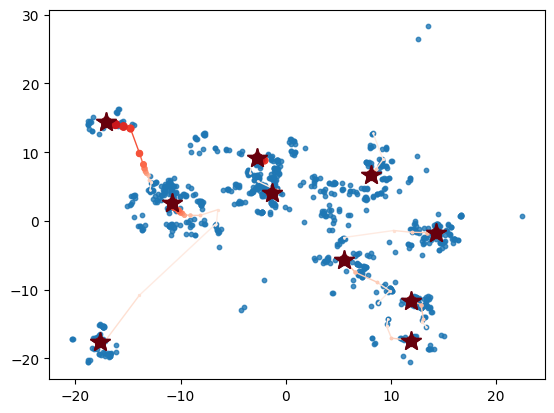

9985.99350038403
9594.548215543977
9494.359099158164
9485.786065426355
9453.48402187787
9443.657806907797
9442.86081901873
9442.86081901873


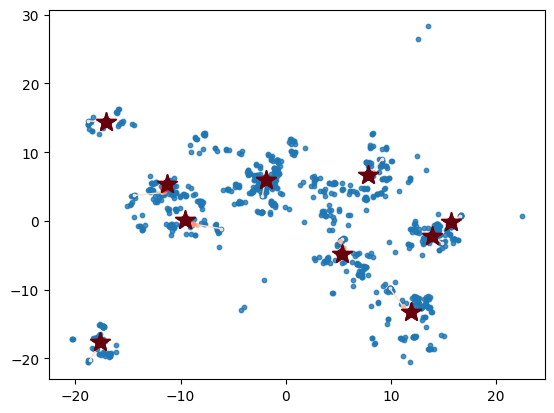

In [39]:
x = create_hierarchical_clusters(100)

all_centers = lloyds(x, 10, init_random)
plot_lloyds(x, all_centers)

all_centers = lloyds(x, 10, init_kmeans_plusplus)
plot_lloyds(x, all_centers)

55145.68586614845
7015.769897708024
5717.317926544419
5716.51316662583
5716.290690365519
5716.290690365519


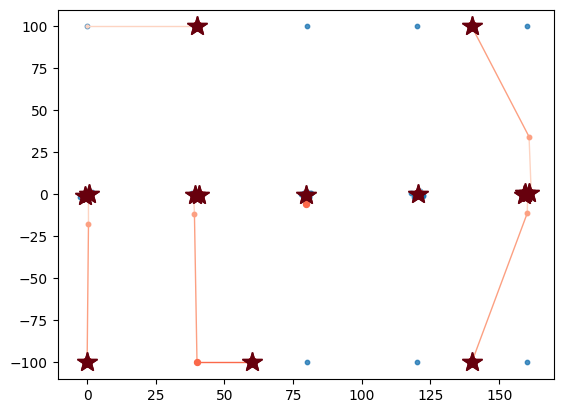

155.17144710445376
155.17144710445376


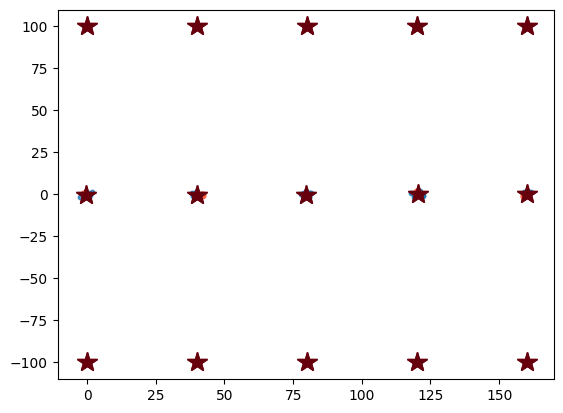

In [26]:
x = create_artificial_bad_dataset(100)

all_centers = lloyds(x, 15, init_random)
plot_lloyds(x, all_centers)

all_centers = lloyds(x, 15, init_kmeans_plusplus)
plot_lloyds(x, all_centers)